<a href="https://colab.research.google.com/github/laure-delisle/gold-busters/blob/main/gee_load_imagery_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=qdkIckB_hBeqNaR7B7FW4OJmmLsSnuRapNSp811zzKQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g73esAAnXLGzl2VBRqeN7pmEUMAKb3mkYD2_xiVKh7KI7__gAThqdk

Successfully saved authorization token.


In [42]:
import ee
import time
import numpy as np
import time
import sys
import json
import argparse

def UTM_lookup(lon):
    assert (lon < 180.0) and (lon >= -180.0)
    # assuming lon in [-180,180)
    return int(np.floor((lon + 180.0)/6) + 1)

def EPSG_lookup(lon,lat):
    utm_zone = UTM_lookup(lon)
    if lat >= 0:
        return 32600 + utm_zone
    else:
        return 32700 + utm_zone

def get_box(lon, lat, patch_extent_m):
    '''
    First selects the right extent using UTM coordinates, then resamples. 
    '''
    query_point = ee.Geometry.Point([lon, lat], crs='EPSG:4326')
    ctr_coords = query_point.getInfo()['coordinates'] # [lon, lat]
    crs_local = 'EPSG:' + str(EPSG_lookup(lon, lat)) # convert to UTM
    ctr_coords_local = query_point.transform(crs_local).getInfo()['coordinates'] # [easting, northing]
    offset = patch_extent_m / 2.0
    ur_coords_local = [ctr_coords_local[0] + offset, ctr_coords_local[1] + offset]
    ll_coords_local = [ctr_coords_local[0] - offset, ctr_coords_local[1] - offset]
    ur = ee.Geometry.Point(ur_coords_local, crs_local).transform('EPSG:4326').getInfo()['coordinates']
    ll = ee.Geometry.Point(ll_coords_local, crs_local).transform('EPSG:4326').getInfo()['coordinates']
    sel_box = ee.Geometry.Rectangle([ll[0], ll[1], ur[0], ur[1]], 'EPSG:4326')
    return sel_box

def export_landsat_series(lon, lat, patch_extent, image_size, fname_base):
    '''
    Exports a time series of (raw) Landsat-8 imagery for a given location. 
    '''
    
    # define series parameters: 
    dataset = 'COPERNICUS/S2_SR' # note: must modify this function if dataset changed
    date_start = '2018-12-01'
    date_end = '2019-02-01'
    
    # get object defining region of interest: 
    query_box = get_box(lon, lat, patch_extent)

    # filter image collection down to those that interect region and dates of interest: 
    ds = ee.ImageCollection(dataset)
    ds = ds.filterBounds(query_box)
    ds = ds.filterDate(date_start,date_end)
    
    # convert image collection to list, sorted by date: 
    num_images = ds.size().getInfo()
    ds_list = ds.sort('system:time_start', True).toList(num_images)
    print('found %d matching images'%(num_images))
    
    task_dict = {}
    max_tasks = 2000 # server-side cap is 3000
    
    for i in range(num_images):
        
        # select current image object: 
        I = ee.Image(ds_list.get(i))
        
        # extract raster of pixel quality attributes:
        I_pixel_qa = I.select('pixel_qa')
        
        # extract raster of radiometric saturation quality attributes: 
        I_radsat_qa = I.select('radsat_qa')
        
        # extract raster of multispectral imagery: 
        I_multispectral = I.select(['B4', 'B3', 'B2'])

        # generate file name: 
        date_str = str(ee.Date(I.get('system:time_start')).format('YYYY-MM-DD').getInfo())
        idx_str = str(i).zfill(5)
        cur_fname = fname_base + '_' + idx_str + '_' + date_str
        print(cur_fname)
        
        # generate other export parameters: 
        export_size = str(image_size)+'x'+str(image_size)
        export_crs = 'EPSG:'+str(EPSG_lookup(lon, lat))
        export_region = query_box.getInfo()['coordinates']
        
        # export multispectral imagery: 
        task_dict[str(i)+'_multispectral'] = ee.batch.Export.image.toDrive(
            image=I_multispectral,
            region=export_region,
            dimensions=export_size,
            crs=export_crs,
            description=cur_fname+'_multispectral',
            folder=fname_base
            )
        task_dict[str(i)+'_multispectral'].start()
        if i == 0:
            time.sleep(30) # pause to allow time for the first to complete - otherwise can get duplicate folders. 
        
        # determine the number of active tasks: 
        num_active = 0
        done_list = []
        for t in task_dict:
            is_active = int(task_dict[t].status()['state'] in ['READY', 'RUNNING'])
            if is_active:
                num_active += 1
            else:
                done_list.append(t)
        print('%d active tasks'%(num_active))
                
        # remove completed jobs from the task dictionary: 
        for t in done_list:
            del task_dict[t]
        
        # wait if too many tasks are active: 
        while num_active >= max_tasks:
            time.sleep(10)

'''
load and parse locations: 
'''

# pp = argparse.ArgumentParser(description='PyTorch MultiLabel Train')
# pp.add_argument('--path-to-file-names', type=str, default='', help='path to npy file containing list of N location names')
# pp.add_argument('--path-to-longitudes', type=str, default='', help='path to npy file containing list of N longitude values')
# pp.add_argument('--path-to-latitudes', type=str, default='', help='path to npy file containing list of N latitude values')
# args = pp.parse_args()

patch_extent = int(2000) # meters
image_size = int(200) # pixels

# loc_names = np.load(args.path_to_file_names) # N location names
# lon_list = np.load(args.path_to_longitudes) # N longitudes
# lat_list = np.load(args.path_to_latitudes) # N latitudes())

loc_names = np.array(["geetest"])
lat_list = np.array([-0.827621582972643])
lon_list = np.array([-78.614217766])

# Note: all images (across time) for location (lon_list[i], lat_list[i]) are 
# saved into a folder named loc_names[i] in Google Drive. 

'''
run earth engine calls: 
'''


assert len(lon_list) == len(lat_list)
    
for i in range(len(lon_list)):
    
    print('processing {}'.format(loc_names[i]))
        
    # export imagery:
    export_landsat_series(lon_list[i], lat_list[i], patch_extent, image_size, "geetest")

# Note: need to execute with -u option if logging isn't working with nohup. 


processing geetest
found 10 matching images
geetest_00000_2018-12-347
0 active tasks
geetest_00001_2018-12-352
1 active tasks
geetest_00002_2018-12-357
2 active tasks
geetest_00003_2018-12-362
3 active tasks
geetest_00004_2019-01-02
4 active tasks
geetest_00005_2019-01-07
5 active tasks
geetest_00006_2019-01-12
6 active tasks
geetest_00007_2019-01-17
7 active tasks
geetest_00008_2019-01-22
8 active tasks
geetest_00009_2019-01-27
9 active tasks


In [12]:
!pip install rasterio

     |████████████████████████████████| 19.1MB 1.4MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0


In [50]:
import rasterio
import os
import matplotlib.pyplot as plt

In [44]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


['/content/drive/MyDrive/geetest/a.tif', '/content/drive/MyDrive/geetest/geetest_00002_2018-12-357_multispectral.tif', '/content/drive/MyDrive/geetest/geetest_00001_2018-12-352_multispectral.tif', '/content/drive/MyDrive/geetest/geetest_00005_2019-01-07_multispectral.tif', '/content/drive/MyDrive/geetest/geetest_00004_2019-01-02_multispectral.tif', '/content/drive/MyDrive/geetest/geetest_00003_2018-12-362_multispectral.tif', '/content/drive/MyDrive/geetest/geetest_00008_2019-01-22_multispectral.tif', '/content/drive/MyDrive/geetest/geetest_00006_2019-01-12_multispectral.tif', '/content/drive/MyDrive/geetest/geetest_00009_2019-01-27_multispectral.tif', '/content/drive/MyDrive/geetest/geetest_00007_2019-01-17_multispectral.tif']
Number of bands in image: 3
Dimensions of image: 200 x 200 (width x height)
<class 'rasterio.io.DatasetReader'>
(200, 200)
(200, 200)
(200, 200)
Number of bands in image: 3
Dimensions of image: 200 x 200 (width x height)
<class 'rasterio.io.DatasetReader'>
(200, 

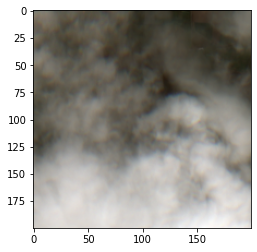

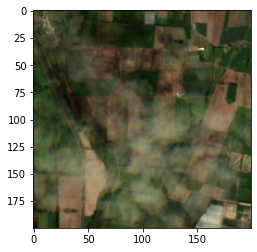

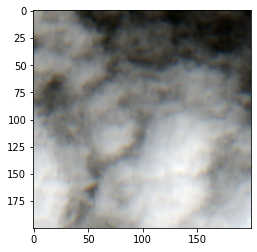

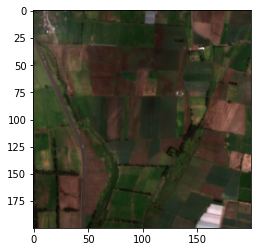

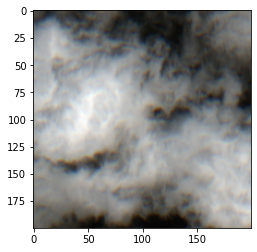

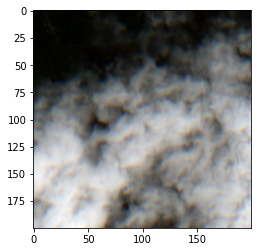

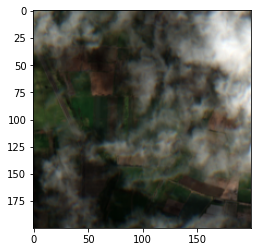

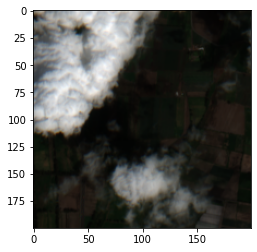

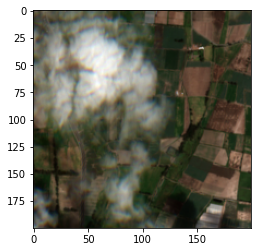

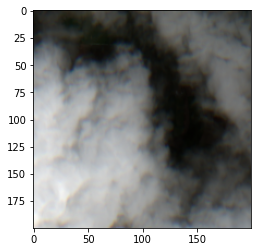

In [56]:
img_names = ['/content/drive/MyDrive/geetest/' + f for f in os.listdir('/content/drive/MyDrive/geetest') if '.tif' in f]
print(img_names)
for name in img_names:
  with rasterio.open(name) as src:
      # How many bands does this image have?
      num_bands = src.count
      print('Number of bands in image: {n}'.format(n=num_bands))
      print('Dimensions of image: {} x {} (width x height)'.format(src.width, src.height))
  
      print(type(src))
      
      
      # Read raster bands to Numpy array
      np_arr_b4 = src.read(1)
      np_arr_b3 = src.read(2)
      np_arr_b2 = src.read(3)


  # Transfer the arrays from server to client and cast as np array.
  
  print(np_arr_b4.shape)
  print(np_arr_b3.shape)
  print(np_arr_b2.shape)
  
  
  np_arr_b4 = 255*(np_arr_b4/np_arr_b4.max())
  np_arr_b3 = 255*(np_arr_b3/np_arr_b3.max())
  np_arr_b2 = 255*(np_arr_b2/np_arr_b2.max())
  
  
  rgb_img = np.dstack((np_arr_b4, np_arr_b3, np_arr_b2)).astype('uint8')
  
  plt.figure()
  plt.imshow(rgb_img)